# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Baseline

Cell Growth under Normal Conditions

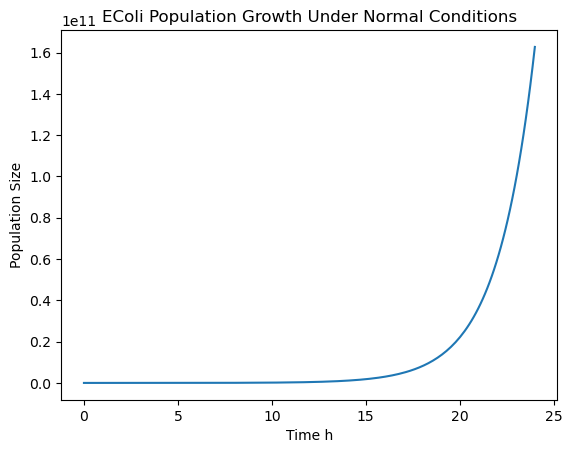

In [2]:
mu_max = 0.5
N0 = 1e6
t = np.linspace(0, 24, 200)

N = N0 * np.exp(mu_max * t)

plt.figure()
plt.plot(t, N)
plt.xlabel("Time h")
plt.ylabel("Population Size")
plt.title("EColi Population Growth Under Normal Conditions")
plt.show()

# Europa

## Functions

Radiation, Temperature, and Growth functions

In [3]:
def f_T(T, T_opt=310, sigma_T=8):
    return np.exp(-((T - T_opt)**2) / (2 * sigma_T**2))

def f_R(R, k=0.00077):
    return np.exp(-k * R)
    
def growth_rate(mu_max, fT, fR):
    return mu_max * fT * fR


class Arad:
    def __init__(self, kappa, N):
        self.kappa = kappa
        self.N = N

    def optical_depth(self):
        return sum(k * n for k, n in zip(self.kappa, self.N))

    def surface_radiation(self, R_space):
        return R_space * np.exp(-self.optical_depth())

    def f_R(self, R, k=0.00077):
        return np.exp(-k * R)


class Atemp:
    def __init__(self, S, A):
        self.S = S
        self.A = A

    def absorbed_flux(self):
        return (1 - self.A) * self.S

    def equilibrium_temperature(self, S_abs):
        sigma = 5.670374419e-8
        return (S_abs / (4 * sigma))**0.25

    def surface_temperature(self, T_eq, G):
        return T_eq * G #No Greenhouse factor so surface temp = equilibruim temp

    def f_T(self, T, T_opt=310, sigma_T=8):
        return np.exp(-((T - T_opt)**2) / (2 * sigma_T**2))

## Surface

### Conditions

In [4]:
kappa = [1e-27]
N = [1e22] 
R_space = 5.4 
S = 51 
A = 0.68 
G = 1.0 # set to 1 so it does 'nothing'
jupiter_heat = 0.05 

### Simulation

In [5]:
class EuropaSurface:
    def __init__(self, kappa, N, R_space, S, A, G, mu_max, jupiter_heat):
        self.mu_max = mu_max
        self.R_space = R_space
        self.jupiter_heat = jupiter_heat
        self.rad = Arad(kappa, N)
        self.temp = Atemp(S, A)
        self.G = G

    def compute(self, lat, time_frac):
        lat_mod = np.cos(np.radians(lat))
        S_abs = self.temp.absorbed_flux() * lat_mod * time_frac + self.jupiter_heat

        T_eq = self.temp.equilibrium_temperature(max(S_abs, 1e-6))
        T_surface = self.temp.surface_temperature(T_eq, self.G)

        R_surface = self.rad.surface_radiation(self.R_space)

        fT = self.temp.f_T(T_surface)
        fR = self.rad.f_R(R_surface)

        mu = growth_rate(self.mu_max, fT, fR)
        return mu, T_surface


surface = EuropaSurface(kappa, N, R_space, S, A, G, mu_max, jupiter_heat)

latitudes = np.linspace(-90, 90, 100)
times = np.linspace(0, 1, 50)

growth_map = np.zeros((len(latitudes), len(times)))

best_mu = 0
best_lat = None
best_time = None
best_T_surface = None

for i, lat in enumerate(latitudes):
    for j, t in enumerate(times):
        mu, T = surface.compute(lat, t)
        growth_map[i, j] = mu

        if mu > best_mu:
            best_mu = mu
            best_lat = lat
            best_time = t
            best_T_surface = T

### Plotting

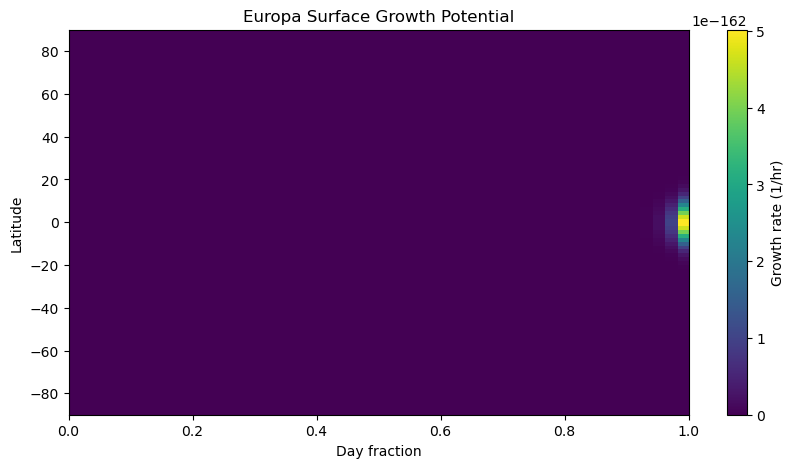

Best surface latitude: -0.91
Surface temperature there: 92.17 K


In [6]:
plt.figure(figsize=(10,5))
plt.imshow(
    growth_map,
    extent=[0, 1, -90, 90],
    origin="lower",
    aspect="auto",
    cmap="viridis"
)
plt.colorbar(label="Growth rate (1/hr)")
plt.xlabel("Day fraction")
plt.ylabel("Latitude")
plt.title("Europa Surface Growth Potential")
plt.show()

print(f"Best surface latitude: {best_lat:.2f}")
print(f"Surface temperature there: {best_T_surface:.2f} K")

## SubSurface

### Condtions

In [7]:
ice_thickness = 20_000
T_surface_avg = 100
T_ocean = 273

### Simulations

In [8]:
def subsurface_temperature(depth):
    return T_surface_avg + (T_ocean - T_surface_avg) * (depth / ice_thickness)

def subsurface_radiation():
    return 0.0 #radiation is negliable 

def subsurface_growth(mu_max, depth):
    T = subsurface_temperature(depth)
    R = subsurface_radiation()
    fT = f_T(T)
    fR = f_R(R)
    mu = growth_rate(mu_max, fT, fR)
    return mu, T


depths = np.linspace(0, ice_thickness, 300)
mu_vals = []
T_vals = []

for d in depths:
    mu, T = subsurface_growth(mu_max, d)
    mu_vals.append(mu)
    T_vals.append(T)

### Plotting

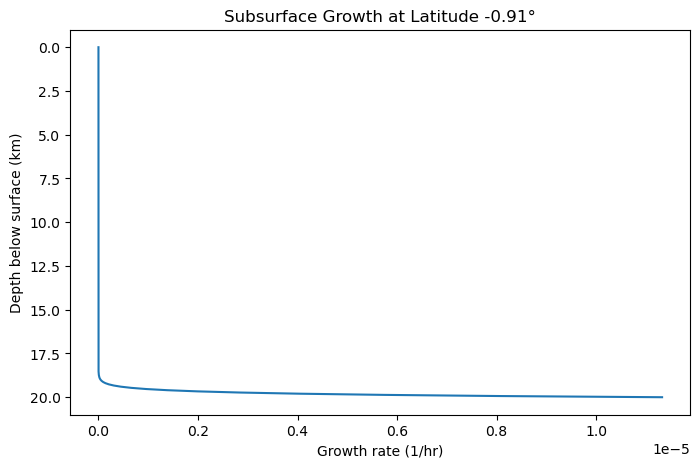

In [9]:
plt.figure(figsize=(8,5))
plt.plot(mu_vals, depths / 1000)
plt.gca().invert_yaxis()
plt.xlabel("Growth rate (1/hr)")
plt.ylabel("Depth below surface (km)")
plt.title(f"Subsurface Growth at Latitude {best_lat:.2f}°")
plt.show()

## Perameter Sensitivity

### SetUp

In [10]:
radiation_values = np.logspace(-2, 2, 50)  # Gy/day
radiation_results = []

ice_thickness_values = np.linspace(5_000, 40_000, 50)  # m
ice_results = []

geothermal_values = np.linspace(0.0, 1.0, 50)  # W/m^2
geothermal_results = []

### Simulation

Run the simulations with changed perameter

#### Radiation

In [11]:
best_lat = best_lat 
time_frac = best_time

for R in radiation_values:
    surface = EuropaSurface(
        kappa=kappa,
        N=N,
        R_space=R,
        S=S,
        A=A,
        G=G,
        mu_max=mu_max,
        jupiter_heat=jupiter_heat
    )

    mu, T = surface.compute(best_lat, time_frac)
    radiation_results.append(mu)

radiation_results = np.array(radiation_results)

#### Ice Thickness

In [12]:
for ice_thickness in ice_thickness_values:
    T_surface_avg = 100
    T_ocean = 273

    def subsurface_temperature(depth):
        return T_surface_avg + (T_ocean - T_surface_avg) * (depth / ice_thickness)

    depths = np.linspace(0, ice_thickness, 100)

    mu_depth = []
    for d in depths:
        T = subsurface_temperature(d)
        fT = f_T(T)
        fR = f_R(0.0)
        mu_depth.append(growth_rate(mu_max, fT, fR))

    ice_results.append(np.max(mu_depth))

ice_results = np.array(ice_results)



#### GeoThermal Heat

In [13]:
for heat in geothermal_values:
    surface = EuropaSurface(
        kappa=kappa,
        N=N,
        R_space=R_space,
        S=S,
        A=A,
        G=G,
        mu_max=mu_max,
        jupiter_heat=heat
    )

    mu, T = surface.compute(best_lat, best_time)
    geothermal_results.append(mu)

geothermal_results = np.array(geothermal_results)


### Analysis

Find perameter that effects growth rate the most

#### Peaks

In [14]:
# Radiation peak
rad_max_idx = np.argmax(radiation_results)
rad_peak = radiation_values[rad_max_idx]
rad_mu = radiation_results[rad_max_idx]

# Ice thickness peak
ice_max_idx = np.argmax(ice_results)
ice_peak = ice_thickness_values[ice_max_idx]
ice_mu = ice_results[ice_max_idx]

# Geothermal peak
heat_max_idx = np.argmax(geothermal_results)
heat_peak = geothermal_values[heat_max_idx]
heat_mu = geothermal_results[heat_max_idx]

print(f"Radiation: peak growth {rad_mu:.2e} 1/hr at R = {rad_peak:.3e} Gy/day")
print(f"Ice thickness: peak growth {ice_mu:.2e} 1/hr at thickness = {ice_peak/1000:.2f} km")
print(f"Geothermal: peak growth {heat_mu:.2e} 1/hr at heat = {heat_peak:.3f} W/m^2")

Radiation: peak growth 5.04e-162 1/hr at R = 1.000e-02 Gy/day
Ice thickness: peak growth 1.13e-05 1/hr at thickness = 5.00 km
Geothermal: peak growth 4.26e-160 1/hr at heat = 1.000 W/m^2


#### Normalization

In [15]:
rad_norm = radiation_results / np.max(radiation_results)
ice_norm = ice_results / np.max(ice_results)
heat_norm = geothermal_results / np.max(geothermal_results)

### Plotting

Growth Rate vs Perameter chosen from analysis

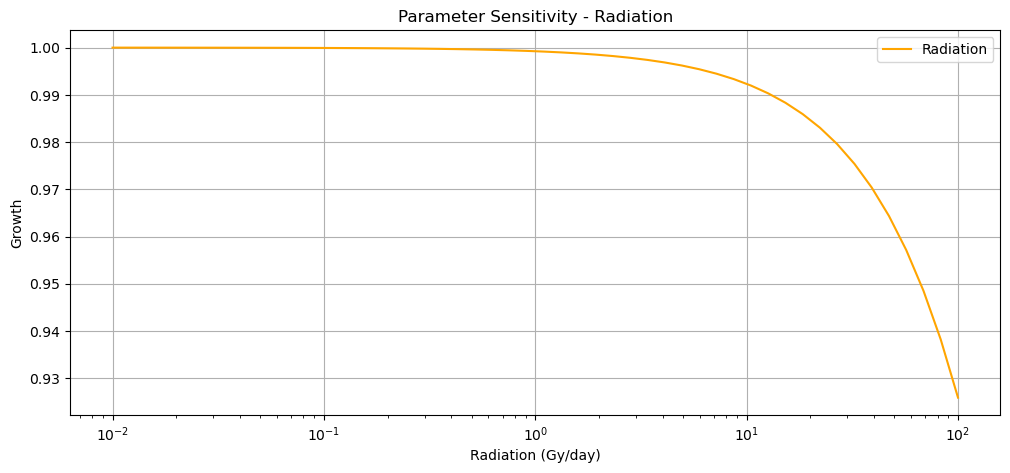

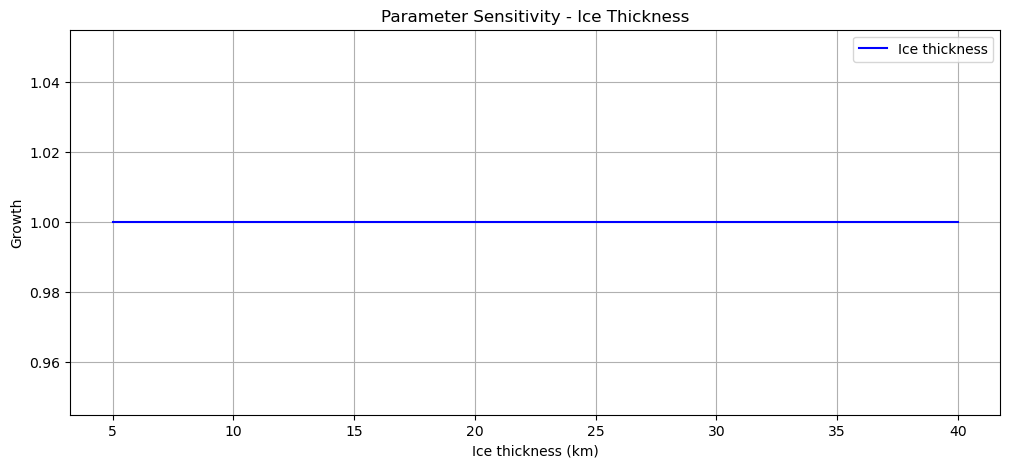

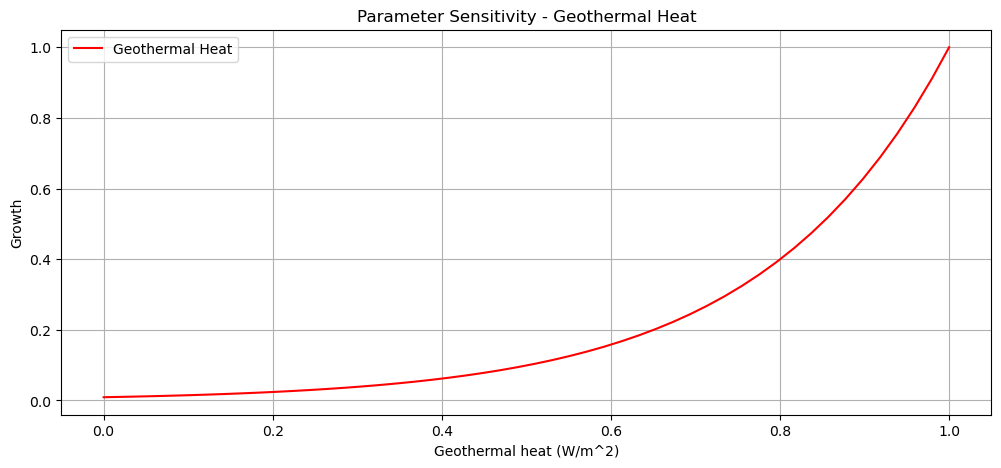

In [16]:
plt.figure(figsize=(12,5))

plt.plot(radiation_values, rad_norm, label="Radiation", color='orange')
plt.xscale('log')
plt.xlabel("Radiation (Gy/day)")
plt.ylabel("Growth")
plt.title("Parameter Sensitivity - Radiation")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(12,5))
plt.plot(ice_thickness_values/1000, ice_norm, label="Ice thickness", color='blue')
plt.xlabel("Ice thickness (km)")
plt.ylabel("Growth")
plt.title("Parameter Sensitivity - Ice Thickness")
plt.grid(True)
plt.legend()
plt.show()

plt.figure(figsize=(12,5))
plt.plot(geothermal_values, heat_norm, label="Geothermal Heat", color='red')
plt.xlabel("Geothermal heat (W/m^2)")
plt.ylabel("Growth")
plt.title("Parameter Sensitivity - Geothermal Heat")
plt.grid(True)
plt.legend()
plt.show()

In [17]:
df_peaks = pd.DataFrame({
    "Parameter": ["Radiation", "Ice thickness", "Geothermal Heat"],
    "Peak Value": [rad_peak, ice_peak/1000, heat_peak],
    "Growth Rate (1/hr)": [rad_mu, ice_mu, heat_mu]
                        })

df_peaks

,Parameter,Peak Value,Growth Rate (1/hr)
0,Radiation,0.01,5.036613e-162
1,Ice thickness,5.00,1.132543e-05
2,Geothermal Heat,1.00,4.263388e-160


# Sources

* https://lasp.colorado.edu/mop/files/2018/07/529-544-with-Images.pdf?utm_source
* https://pmc.ncbi.nlm.nih.gov/articles/PMC182851/pdf/aem00057-0212.pdf
* https://dl.icdst.org/pdfs/files3/bcc9d7674e67c664d212d5887e7900c7.pdf
* https://www.nature.com/articles/s41550-025-02718-0
* https://pmc.ncbi.nlm.nih.gov/articles/PMC6595243/?utm_source
* https://academic.oup.com/mnras/article/540/1/1329/8137882?login=false&utm_source
* Lissauer, Jack J. & De Pater, Imke (2013). Fundamental Planetary Science: Physics, Chemistry, and Habitability. Cambridge University Press (https://api.pageplace.de/preview/DT0400.9781107352117_A23760900/preview-9781107352117_A23760900.pdf)
* https://www.gnss-x.ac.cn/docs/Atmospheric%20Science%20An%20Introductory%20Survey%20(John%20M.%20Wallace,%20Peter%20V.%20Hobbs)%20(z-lib.org).pdf
* https://faculty.washington.edu/dcatling/Robinson2012_AnalyticRadConv_ApJ.pdf
* https://garcialab.berkeley.edu/courses/papers/Monod1949.pdf
* https://pubmed.ncbi.nlm.nih.gov/29579907/
* https://pmc.ncbi.nlm.nih.gov/articles/PMC217594/pdf/jbacter00247-0200.pdf
* https://pmc.ncbi.nlm.nih.gov/articles/PMC3736669/
* https://ia600208.us.archive.org/16/items/fundamentals-of-heat-and-mass-transfer-theodore-l.-bergman-adrienne-s.-lavine-fr/Fundamentals%20of%20Heat%20and%20Mass%20Transfer%20--%20Theodore%20L.%20Bergman%2C%20Adrienne%20S.%20Lavine%2C%20Frank%20P.%20Incropera%2C%20--%208th%2C%202017%20--%20Wiley%20--%209781118989173%20--%20ebe985ff177850912fb0e80779ba4103%20--%20Anna%E2%80%99s%20Archive.pdf
* https://pmc.ncbi.nlm.nih.gov/articles/PMC9147769/